In [78]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
# import seaborn as sns
from numpy.linalg import solve
import matplotlib.pyplot as plt

In [2]:
train = np.load('../data/train_sparse_matrix.npy')
valid = np.load('../data/valid_sparse_matrix.npy')
train_valid = np.load('../data/train_valid_sparse_matrix.npy')
test = np.load('../data/test_sparse_matrix.npy')

# MSE & MAE

In [76]:
def get_mse(pred, actual):
        # Ignore nonzero terms.
        pred = pred[actual.nonzero()].flatten()
        actual = actual[actual.nonzero()].flatten()
        
        return mean_squared_error(pred, actual)
    
def get_mae(pred, actual):
        # Ignore nonzero terms.
        pred = pred[actual.nonzero()].flatten()
        actual = actual[actual.nonzero()].flatten()
        
        return mean_absolute_error(pred, actual)

# ALS

In [38]:
class ExplicitMF_ALS():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
    def calculate_learning_curve(self, iter_array, test):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print ('Train mse: ' + str(self.train_mse[-1]))
                print ('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter
        return self.train_mse[-1], self.test_mse[-1], predictions

# Optimize ALS model parameter

In [9]:
# latent_factors = [5, 20, 40, 80]
# regularizations = [0.1, 1., 10., 100.]
# regularizations.sort()
# iter_array = [1, 2, 5, 10]

# best_params = {}
# best_params['n_factors'] = latent_factors[0]
# best_params['reg'] = regularizations[0]
# best_params['n_iter'] = 0
# best_params['train_mse'] = np.inf
# best_params['test_mse'] = np.inf
# best_params['model'] = None

# start_time = time.time()
# for fact in latent_factors:
#     print('Factors: {}'.format(fact))
#     for reg in regularizations:
#         print('Regularization: {}'.format(reg))
#         MF_ALS = ExplicitMF_ALS(train, n_factors=fact, user_reg=reg, item_reg=reg)
#         MF_ALS.calculate_learning_curve(iter_array, test)
#         min_idx = np.argmin(MF_ALS.test_mse)
#         if MF_ALS.test_mse[min_idx] < best_params['test_mse']:
#             best_params['n_factors'] = fact
#             best_params['reg'] = reg
#             best_params['n_iter'] = iter_array[min_idx]
#             best_params['train_mse'] = MF_ALS.train_mse[min_idx]
#             best_params['test_mse'] = MF_ALS.test_mse[min_idx]
#             best_params['model'] = MF_ALS
#             print ('New optimal hyperparameters')
#             print (pd.Series(best_params))
    
# end_time = time.time()
# print(f'running time: {end_time-start_time}')

# best_als_model = best_params['model']

# Results 

### Factors: 5
Regularization: 0.1
New optimal hyperparameters
n_factors                                                    5
reg                                                        0.1
n_iter                                                      10
train_mse                                               14.529
test_mse                                               16.5731
model        <__main__.ExplicitMF_ALS object at 0x7f932f37a...
dtype: object
Regularization: 1.0
Regularization: 10.0
Regularization: 100.0
Factors: 20
Regularization: 0.1
New optimal hyperparameters
n_factors                                                   20
reg                                                        0.1
n_iter                                                      10
train_mse                                              13.1969
test_mse                                               16.5401
model        <__main__.ExplicitMF_ALS object at 0x7f93d7a08...
dtype: object
Regularization: 1.0
Regularization: 10.0
Regularization: 100.0
Factors: 40
Regularization: 0.1
Regularization: 1.0
Regularization: 10.0
Regularization: 100.0
Factors: 80
Regularization: 0.1
Regularization: 1.0
Regularization: 10.0
Regularization: 100.0
running time: 3550.5916318893433 --> -->

# Plot

In [71]:
reg = 0.1
iter_array = [10]
n_factors = [5,10,15,20,25,30,35,40]
train_mse_lst = []
valid_mse_lst = []

start_time = time.time()

for k in n_factors:
    print('Factors: {}'.format(k))
    MF_ALS = ExplicitMF_ALS(train, n_factors=k, user_reg=reg, item_reg=reg)
    train_mse, valid_mse, _ = MF_ALS.calculate_learning_curve(iter_array, test)
    train_mse_lst.append(train_mse)
    valid_mse_lst.append(valid_mse)
    
end_time = time.time()
print(f'running time: {end_time-start_time}')

Factors: 5
Factors: 10
Factors: 15
Factors: 20
Factors: 25
Factors: 30
Factors: 35
Factors: 40
running time: 662.7320938110352


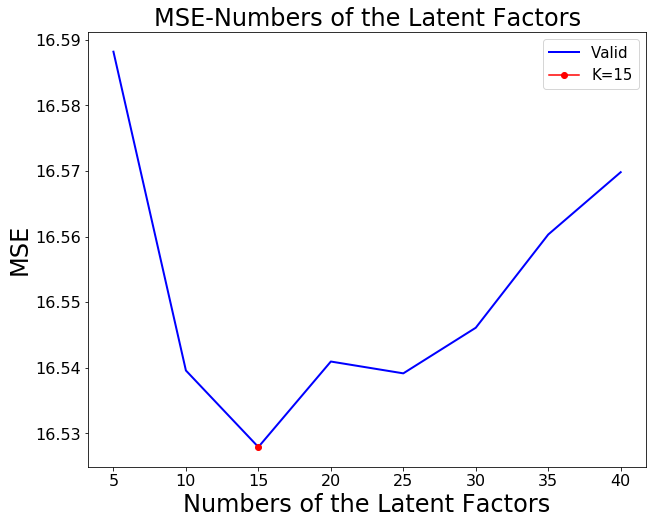

In [72]:
fig, ax = plt.subplots(figsize=(10,8))

# plt.plot(n_factors, train_mse_lst, label='Training', linewidth=5, color='blue')
plt.plot(n_factors, valid_mse_lst, label='Valid', linewidth=2, color='blue')
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.plot(15, valid_mse_lst[2], 'r-o', label='K=15')

plt.xlabel('Numbers of the Latent Factors', fontsize=24);
plt.ylabel('MSE', fontsize=24);
plt.legend(loc='best', fontsize=15);
plt.title('MSE-Numbers of the Latent Factors', fontsize=24)
plt.show()

# Valid-Sparse-Matrix Prediction

In [73]:
reg = 0.1
iter_array = [10]
n = 15

tuned_model = ExplicitMF_ALS(train_valid, n_factors=n, user_reg=reg, item_reg=reg)
train_mse, valid_mse, prediction = tuned_model.calculate_learning_curve(iter_array, valid)

np.save('../data/test_prediction_CF_ALS.npy', prediction)

In [74]:
als_mse = get_mse(prediction, valid)
als_mse

16.43281890816601

In [79]:
als_mae = get_mae(prediction, valid)
als_mae

3.8369603607763727

# SGD

In [60]:
class ExplicitMF_SGD():
    def __init__(self, 
                 ratings,
                 n_factors,
                 item_fact_reg, 
                 user_fact_reg,
                 item_bias_reg,
                 user_bias_reg,
                 learning='sgd',
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print ('Train mse: ' + str(self.train_mse[-1]))
                print ('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter
        return self.train_mse[-1], self.test_mse[-1], predictions

# Optimize SGD model parameters

In [59]:
# latent_factors = [5,10,15,20,25,30,35,40]
# bias_regularizations = [0.1, 1., 10.]
# fact_regularizations = [0.1, 1., 10.]
# iter_array = [1, 2, 5, 10]
# learning_rates = [1e-2, 1e-1]

# best_params = {}
# best_params['n_factors'] = latent_factors[0]
# best_params['fact_reg'] = fact_regularizations[0]
# best_params['bias_reg'] = bias_regularizations[0]
# best_params['learning_rate'] = None
# best_params['n_iter'] = 0
# best_params['train_mse'] = np.inf
# best_params['test_mse'] = np.inf
# best_params['model'] = None

# start_time = time.time()
# for fact in latent_factors:
#     print('Factors: {}'.format(fact))
#     for fact_reg in fact_regularizations:
#         print('Fact_Regularization: {}'.format(fact_reg))
#         for bias_reg in bias_regularizations:
#             print('Bias_Regularization: {}'.format(bias_reg))
#             for rate in learning_rates:
#                 print ('Rate: {}'.format(rate))
                
#                 MF_SGD = ExplicitMF_SGD(train, n_factors=k, \
#                                         user_fact_reg=fact_reg, item_fact_reg=fact_reg,\
#                                         user_bias_reg=bias_reg, item_bias_reg=bias_reg, learning='sgd')
                
#                 MF_SGD.calculate_learning_curve(iter_array, valid, learning_rate=rate)
#                 min_idx = np.argmin(MF_SGD.test_mse)
#                 if MF_SGD.test_mse[min_idx] < best_params['test_mse']:
                    
#                     best_params['n_factors'] = fact
#                     best_params['fact_reg'] = fact_reg
#                     best_params['bias_reg'] = bias_reg
#                     best_params['n_iter'] = iter_array[min_idx]
#                     best_params['learning_rate'] = rate
#                     best_params['train_mse'] = MF_SGD.train_mse[min_idx]
#                     best_params['test_mse'] = MF_SGD.test_mse[min_idx]
#                     best_params['model'] = MF_SGD
                    
#                     print ('New optimal hyperparameters')
#                     print (pd.Series(best_params))

# Plot

In [65]:
reg = 0.1
iter_array = [10]
n_factors = [5,10,15,20,25,30,35,40]
train_mse_lst = []
valid_mse_lst = []

start_time = time.time()

for k in n_factors:
    print('Factors: {}'.format(k))
    MF_SGD = ExplicitMF_SGD(train, n_factors=k, item_fact_reg=reg, user_fact_reg=reg, user_bias_reg=reg, item_bias_reg=reg)
    train_mse, valid_mse, predictions = MF_SGD.calculate_learning_curve(iter_array, valid, learning_rate=0.01)
    train_mse_lst.append(train_mse)
    valid_mse_lst.append(valid_mse)
    
end_time = time.time()
print(f'running time: {end_time-start_time}')

Factors: 5
Factors: 10
Factors: 15
Factors: 20
Factors: 25
Factors: 30
Factors: 35
Factors: 40
running time: 35923.28186225891


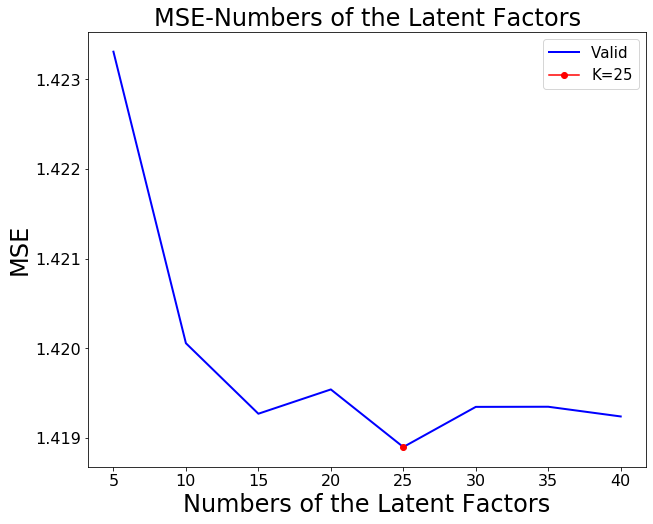

In [69]:
fig, ax = plt.subplots(figsize=(10,8))

# plt.plot(n_factors, train_mse_lst, label='Training', linewidth=5, color='blue')
plt.plot(n_factors, valid_mse_lst, label='Valid', linewidth=2, color='blue')
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.plot(25, valid_mse_lst[4], 'r-o', label='K=25')

plt.xlabel('Numbers of the Latent Factors', fontsize=24);
plt.ylabel('MSE', fontsize=24);
plt.legend(loc='best', fontsize=15);
plt.title('MSE-Numbers of the Latent Factors', fontsize=24)
plt.show()

# Valid-Sparse-Matrix Prediction

In [91]:
iter_array =  [10]
learning_rates = [0.01]
n=25

MF_SGD = ExplicitMF_SGD(train, n_factors=n, item_fact_reg=0.1, user_fact_reg=0.1, user_bias_reg=0.1, item_bias_reg=0.1, verbose=True)
train_mse, test_mse, predictions = MF_SGD.calculate_learning_curve(iter_array, valid, learning_rate=0.01)

np.save('../data/test_prediction_CF_SGD.npy', predictions)

Iteration: 10
	current iteration: 10
Train mse: 1.0192969741918814
Test mse: 1.4178860388775774


In [92]:
sgd_mse = get_mse(predictions, valid)
sgd_mse

1.4178860388775774

In [93]:
sgd_mae = get_mae(predictions, valid)
sgd_mae

0.9477884332870176